# StreamMultiDiffusion Region-Based Semantic Control Demo

For additional info, please consult our paper: [StreamMultiDiffusion: Real-Time Interactive Generation with Region-Based Semantic Control](https://arxiv.org/abs/2403.09055).

## Preparation

In [1]:
seed = 1
device = 0

In [2]:
import sys
import time
import warnings

sys.path.append('../src')
warnings.filterwarnings('ignore')

import torch
import torchvision.transforms as T
from PIL import Image
from diffusers.utils import make_image_grid
from functools import reduce

from util import seed_everything, blend
from model import StableMultiDiffusionSDXLPipeline
from ipython_util import dispt
from prompt_util import print_prompts, preprocess_prompts


seed_everything(seed)
device = f'cuda:{device}'
print(f'[INFO] Initialized with seed  : {seed}')
print(f'[INFO] Initialized with device: {device}')

[INFO] Initialized with seed  : 1
[INFO] Initialized with device: cuda:0


# Run

## Step 1: Load a StreamMultiDiffusion pipeline.

In [3]:
smd = StableMultiDiffusionSDXLPipeline(
    device,
    hf_key='cagliostrolab/animagine-xl-3.1',
    has_i2t=False,
)

[INFO] Loading Stable Diffusion...
[INFO] Using Hugging Face custom model key: cagliostrolab/animagine-xl-3.1


Loading pipeline components...: 100%|████████████| 7/7 [00:01<00:00,  5.94it/s]


[INFO] Model is loaded!


## Step 2: Load *semantic palette*, i.e., prompts and masks.

[INFO] Loading masks...


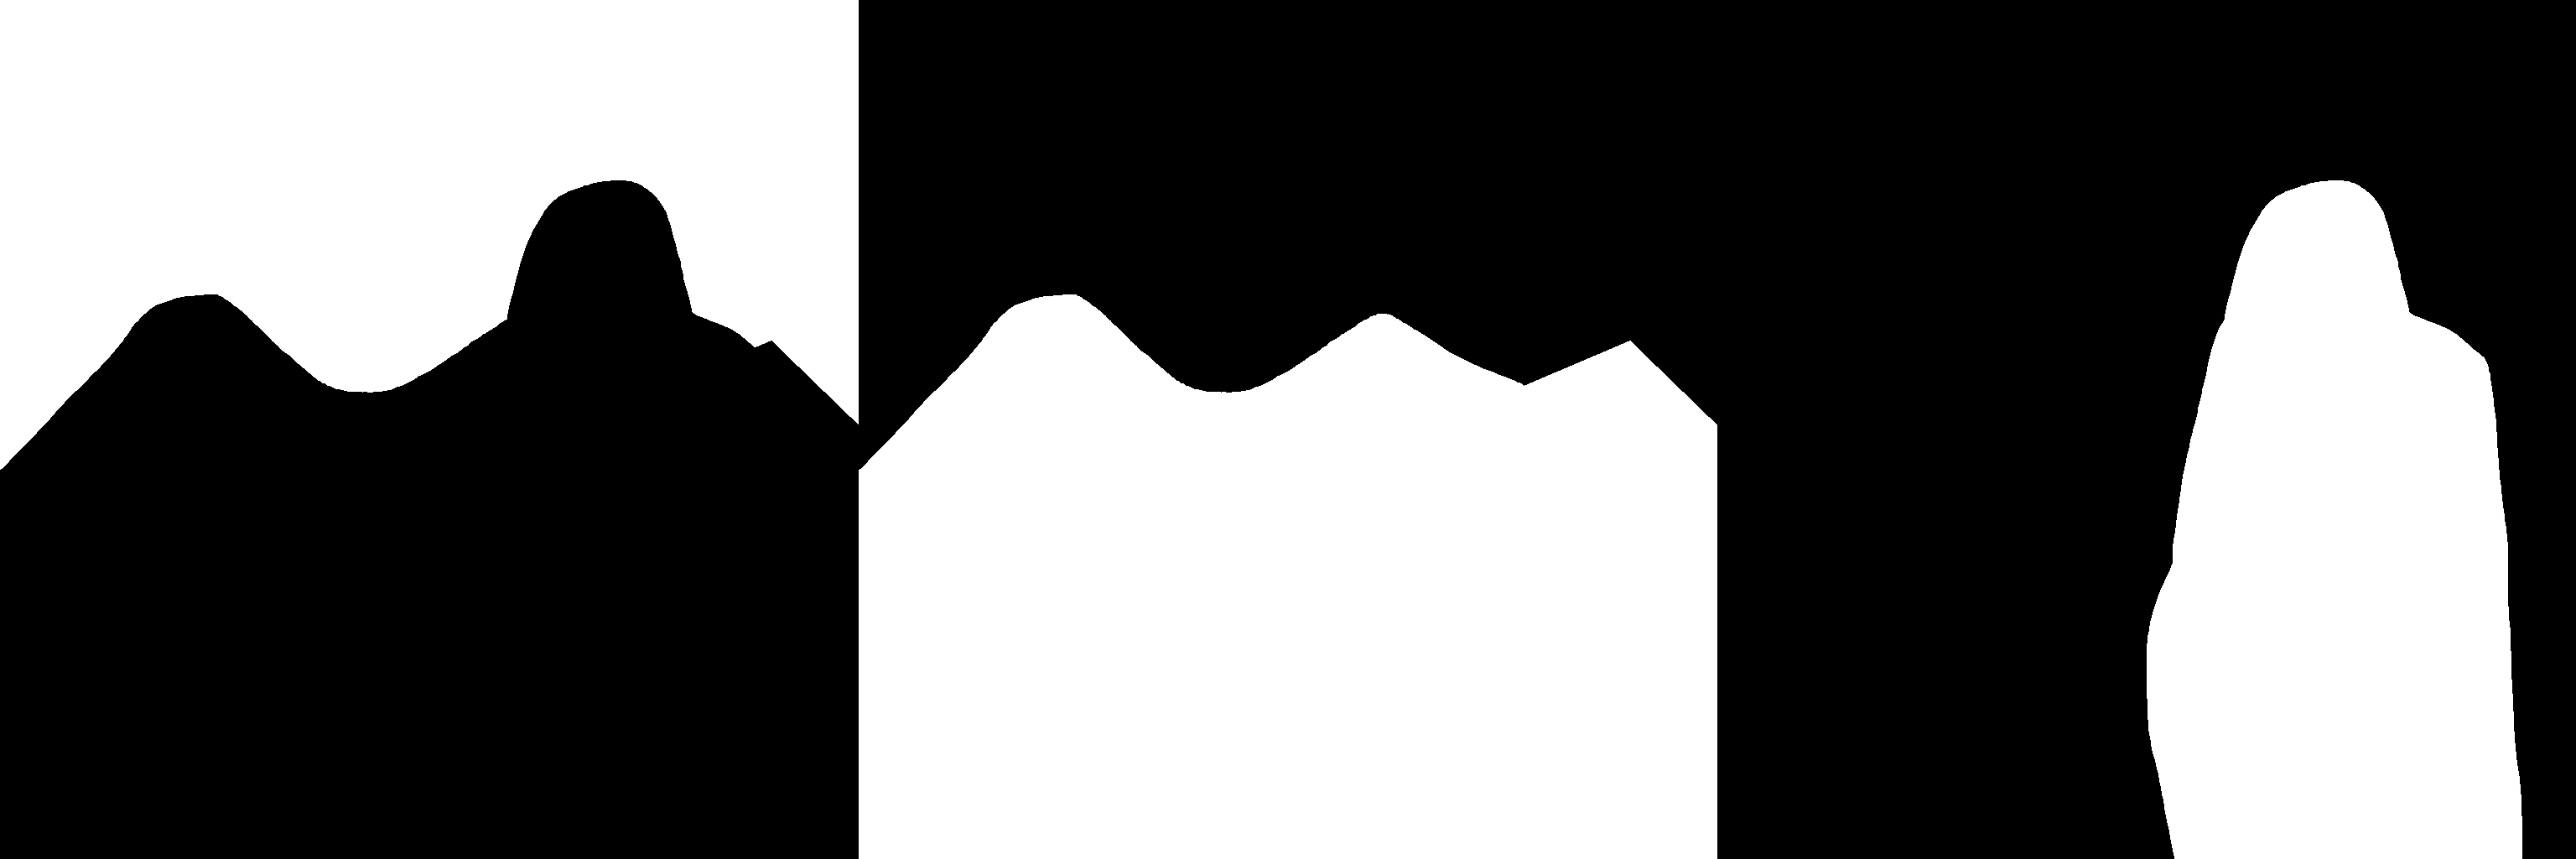

[INFO] Loading prompts...
Background Prompt: purple sky, planets, planets, planets, stars, stars, stars, masterpiece, best quality, very aesthetic, absurdres
Prompt1: a photo of the dolomites, masterpiece, absurd quality, background, no humans, masterpiece, best quality, very aesthetic, absurdres
Prompt2: 1girl, looking at viewer, pretty face, blue hair, fantasy style, witch, magi, robe, masterpiece, best quality, very aesthetic, absurdres
Background Negative Prompt: nsfw, lowres, (bad), text, error, fewer, extra, missing, worst quality, jpeg artifacts, low quality, watermark, unfinished, displeasing, oldest, early, chromatic aberration, signature, extra digits, artistic error, username, scan, [abstract], worst quality, bad quality, normal quality, cropped, framed, 1girl, 1boy, humans, humans, humans
Negative Prompt1: nsfw, lowres, (bad), text, error, fewer, extra, missing, worst quality, jpeg artifacts, low quality, watermark, unfinished, displeasing, oldest, early, chromatic aberrati

In [4]:
# Prepare masks.
print('[INFO] Loading masks...')

name = 'fantasy_large'
mask_all = Image.open(f'../assets/{name}/{name}_full.png').convert('RGBA')
masks = [Image.open(f'../assets/{name}/{name}_{i}.png').convert('RGBA') for i in range(1, 3)]
masks = [(T.ToTensor()(mask)[-1:] > 0.5).float() for mask in masks]
# Background is simply non-marked set of pixels.
background = reduce(torch.logical_and, [m == 0 for m in masks])
dispt([background] + masks, row=1)

masks = torch.stack([background] + masks, dim=0)
mask_strengths = 1.0
mask_stds = 0.0

###

# Prepare prompts.
print('[INFO] Loading prompts...')

prompts = [
    # Background prompt.
    'purple sky, planets, planets, planets, stars, stars, stars',
    # Foreground prompts.
    'a photo of the dolomites, masterpiece, absurd quality, background, no humans',
    '1girl, looking at viewer, pretty face, blue hair, fantasy style, witch, magi, robe',
]
negative_prompts = [
    '1girl, 1boy, humans, humans, humans',
    '1girl, 1boy, humans, humans, humans',
    '',
]
negative_prompt_prefix = 'worst quality, bad quality, normal quality, cropped, framed'
negative_prompts = [negative_prompt_prefix + ', ' + p for p in negative_prompts]

###

# Preprocess prompts for better results.
quality_name = 'Standard v3.1'
style_name = '(None)'

prompts, negative_prompts = preprocess_prompts(
    prompts, negative_prompts, style_name=style_name, quality_name=quality_name)

###

print_prompts(prompts, negative_prompts, has_background=True)
height, width = masks.shape[-2:]

## Step 3: Generate images from multiple text prompts in 10 seconds!

100%|████████████████████████████████████████████| 5/5 [00:04<00:00,  1.22it/s]


Elapsed Time: 6.924734354019165


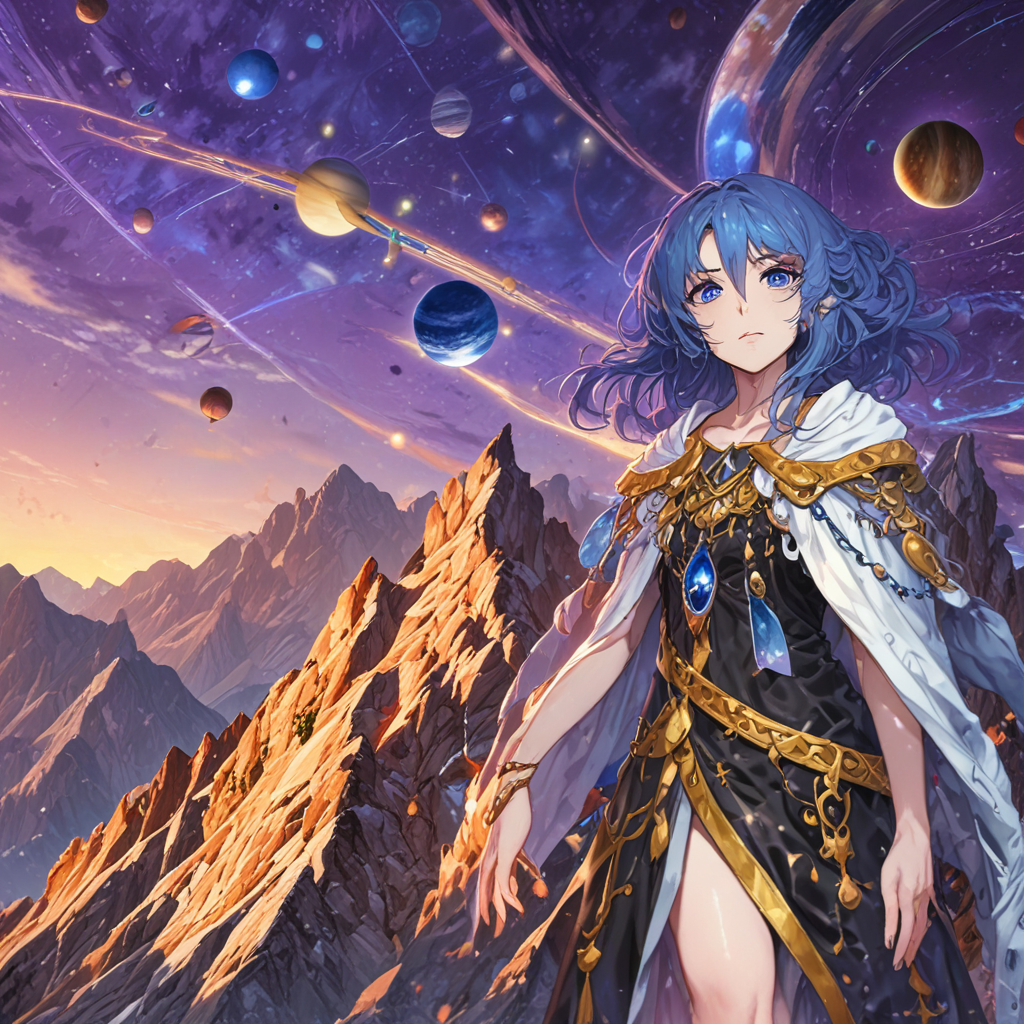

In [5]:
tic = time.time()
img = smd(
    prompts, negative_prompts, masks=masks.float(),
    mask_stds=mask_stds, mask_strengths=mask_strengths,
    height=height, width=width, bootstrap_steps=2,
    guidance_scale=0,
)
toc = time.time()
print(f'Elapsed Time: {toc - tic}')
display(img)